In [1]:
import nemo.collections.asr as nemo_asr
import librosa
import os
import random
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.pyplot as plt

home_path = '/home/ubuntu'

2023-03-07 00:46:42.463172: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-07 00:46:42.567021: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-03-07 00:46:43.091697: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-03-07 00:46:43.091749: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] 

In [2]:
speaker_model = nemo_asr.models.EncDecSpeakerLabelModel.from_pretrained(model_name='titanet_large')

[NeMo I 2023-03-07 00:46:45 cloud:56] Found existing object /home/ubuntu/.cache/torch/NeMo/NeMo_1.15.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2023-03-07 00:46:45 cloud:62] Re-using file from: /home/ubuntu/.cache/torch/NeMo/NeMo_1.15.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2023-03-07 00:46:45 common:913] Instantiating model from pre-trained checkpoint


[NeMo W 2023-03-07 00:46:46 modelPT:156] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2023-03-07 00:46:46 modelPT:163] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valida

[NeMo I 2023-03-07 00:46:46 label_models:126] Setting angular: true/false in decoder is deprecated and will be removed in 1.13 version, use specific loss with _target_
[NeMo I 2023-03-07 00:46:46 features:267] PADDING: 16
[NeMo I 2023-03-07 00:46:46 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /home/ubuntu/.cache/torch/NeMo/NeMo_1.15.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.


## Introduction

The goal of this workbook is to test and experiment with different audio file encoding mechanisms. The goal here is to understand if given enough data wheter we can implement a embedding system that will be able to detect differences between real data and fake data.

The goal of this workbook is to answer a few questions:
- Can we use out of the box pre-trained models for our problem?
- What is the added benefit of fine-tuning the model using generated fakes?
- How much data would be required to run fine-tuning?
- Is there any reason to self-train the model?
- How much data would we need self-train the model?
- Can we increase the amount of data through data augmentation?
- In general, what is the right length of each audio file to be useful

To start, we will be using an out of the box model from NVIDIA NeMo called titanet_large. 

https://arxiv.org/pdf/2110.04410.pdf 


In [3]:
def normalize(ar):
    return (ar - np.mean(ar, axis=0))/np.std(ar, axis=0)

In [4]:
def load_data(folder_path, file_names=None):
    file_paths = list(os.listdir(os.path.join(home_path, folder_path)))
    
    if isinstance(file_names, type(None)):
        file_paths = [os.path.join(home_path, folder_path, file_path) for file_path in file_paths]
    else:
        file_paths = [os.path.join(home_path, folder_path, file_path) for file_path in file_paths if file_path in file_names]
    return file_paths

In [5]:
def get_embeddings(model, file_paths):
    embeddings = np.array([model.get_embedding(file_path).cpu().detach().numpy()[0] for file_path in file_paths])
    
    if normalize:
        pass
        #embeddings = normalize(embeddings)
    
    np.random.shuffle(embeddings)
    return embeddings

In [6]:
def get_TSNE_Embeddings(X):
    tsne = TSNE(n_components=2, learning_rate='auto', init='random')
    return tsne.fit_transform(X)

In [7]:
def model_and_eval(X, y, model):
    
    #split into test/train
    X_train, X_test, y_train, y_test =train_test_split(X, y, shuffle=True)
    
    # create the model
    model.fit(X_train, y_train)

    pred_train = model.predict(X_train) 
    pred_test = model.predict(X_test) 
    
    #evaluate
    print('Training Accuracy')
    print('-------------------------------')
    train_acc = accuracy_score(y_true=y_train, y_pred=pred_train)
    print(f'Acc: {train_acc:.2f}')

    print()

    print('Testing Accuracy')
    print('-------------------------------')
    test_acc = accuracy_score(y_true=y_test, y_pred=pred_test)
    print(f'Acc: {test_acc:.2f}')
    
    return model
    

## Experiment #1
For our first test, we will see how the TitaNet Large performs on the easy task of seperating Biden and Obama audio clips. '

We will generate embeddings for audio clips for each speaker. With these embeddings, we will analyze them in two different ways:
1. Run a simple classification model to see if we can find separation between the two voices
2. Plot the embeddings using T-SNE and see if there are clear clusters in the data

### Load the Data and Model

In [8]:
#read in Biden and Obama Data
biden_wav_folder = 'data/world-leaders-dataset/WavFiles/biden_wav_audio/16000KHz'
obama_wav_folder = 'data/world-leaders-dataset/WavFiles/obama_wav_audio/16000KHz'

biden_file_paths = load_data(biden_wav_folder)
obama_file_paths = load_data(obama_wav_folder)

### Generate Embeddings and Labels

In [9]:
balance_classes = True

In [10]:
biden_embeddings = get_embeddings(model=speaker_model, file_paths=biden_file_paths)
obama_embeddings = get_embeddings(model=speaker_model, file_paths=obama_file_paths)

if balance_classes:
    num_samples = min(len(biden_embeddings), len(obama_embeddings))
    biden_embeddings = biden_embeddings[:num_samples,:]
    obama_embeddings = obama_embeddings[:num_samples,:]
    
    biden_labels = [1]*num_samples
    obama_labels = [0]*num_samples
else:
    biden_labels = [1]*biden_embeddings.shape[0]
    obama_labels = [0]*obama_embeddings.shape[0]

[NeMo W 2023-03-07 00:46:47 nemo_logging:349] /home/ubuntu/miniconda3/envs/nemo/lib/python3.8/site-packages/nemo/collections/asr/models/label_models.py:437: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1670525491394/work/torch/csrc/utils/tensor_new.cpp:230.)
      torch.tensor([audio], device=device),
    


## Run and Evaluate Classifier

In [11]:
#combine the data
X = np.concatenate((biden_embeddings, obama_embeddings), axis=0)
y = np.concatenate((biden_labels, obama_labels))

In [12]:
model = KNeighborsClassifier()
model = model_and_eval(X, y, model)

Training Accuracy
-------------------------------
Acc: 1.00

Testing Accuracy
-------------------------------
Acc: 1.00


### Plot the TSNE


In [13]:
viz_samples = 50

biden_embeddings_viz = biden_embeddings[:viz_samples,:]
obama_embeddings_viz = obama_embeddings[:viz_samples,:]

X_viz = np.concatenate((biden_embeddings_viz, obama_embeddings_viz))

X_embed = get_TSNE_Embeddings(X_viz)

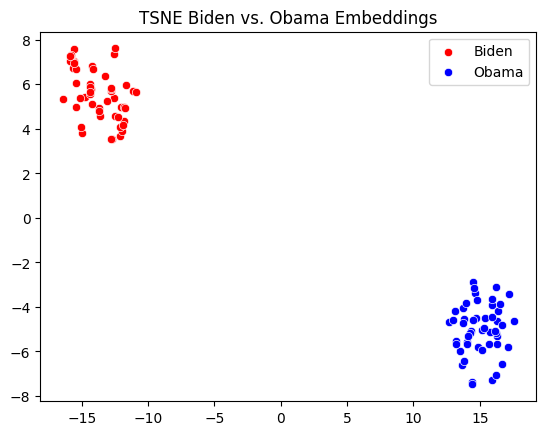

In [14]:
sns.scatterplot(x=X_embed[:50,0], y=X_embed[:50,1], color='red', label='Biden')
sns.scatterplot(x=X_embed[50:,0], y=X_embed[50:,1], color='blue', label='Obama')
plt.title('TSNE Biden vs. Obama Embeddings')
plt.show()

## Experiment #2

The model is able to easily differentiate between Biden and Obama's voice. We will now test if the out-of-the-box embeddings is able to differentiate between fake Biden audio clips created by ElevenLabs and real Biden clips.

### Load the Data

In [15]:
#read in Biden fake data
#we already have the real Biden Speech Embeddings, so no need to re-pull those
biden_fake_wav_folder = 'data/world-leaders-dataset/11LabsDeepFakes/16000KHz'

biden_fake_file_paths = load_data(biden_fake_wav_folder)

### Generate Embeddings and Labels

In [16]:
balance_classes = True

In [17]:
biden_real_embeddings = biden_embeddings #renaming for ease of reading
biden_fake_embeddings = get_embeddings(model=speaker_model, file_paths=biden_fake_file_paths)

if balance_classes:
    num_samples = min(len(biden_real_embeddings), len(biden_fake_embeddings))
    biden_real_embeddings = biden_real_embeddings[:num_samples,:]
    biden_fake_embeddings = biden_fake_embeddings[:num_samples,:]
    
    biden_real_labels = [1]*num_samples
    biden_fake_labels = [0]*num_samples
else:
    biden_real_labels = [1]*biden_real_embeddings.shape[0]
    biden_faake_labels = [0]*biden_fake_embeddings.shape[0]

### Run and Evaluate Model


In [18]:
#combine the data
X = np.concatenate((biden_real_embeddings, biden_fake_embeddings), axis=0)
y = np.concatenate((biden_real_labels, biden_fake_labels))

In [19]:
model = KNeighborsClassifier()
model = model_and_eval(X, y, model)

Training Accuracy
-------------------------------
Acc: 1.00

Testing Accuracy
-------------------------------
Acc: 1.00


### Plot the TSNE

In [20]:
viz_samples = 50

biden_real_embeddings_viz = biden_real_embeddings[:viz_samples,:]
biden_fake_embeddings_viz = biden_fake_embeddings[:viz_samples,:]

X_viz = np.concatenate((biden_real_embeddings_viz, biden_fake_embeddings_viz))

X_embed = get_TSNE_Embeddings(X_viz)

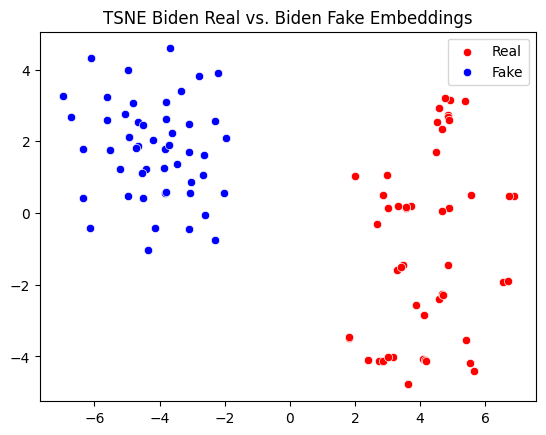

In [21]:
sns.scatterplot(x=X_embed[:viz_samples,0], y=X_embed[:viz_samples,1], color='red', label='Real')
sns.scatterplot(x=X_embed[viz_samples:,0], y=X_embed[viz_samples:,1], color='blue', label='Fake')
plt.title('TSNE Biden Real vs. Biden Fake Embeddings')
plt.show()

## Experiment #3

We see the model performs really well with ElevenLabs Data. We will also get the embeddings for a few deepfakes from the wild.

In [22]:
itw_reddit = os.path.join(home_path,'data/InTheWildFakes/Biden/16000KHz/biden-reddit-fake.wav')
itw_twitter = os.path.join(home_path,'data/InTheWildFakes/Biden/16000KHz/biden-twitter-fake.wav')
itw_twitter2 = os.path.join(home_path,'data/InTheWildFakes/Biden/16000KHz/jb-twitter-2-df-16khz.wav')
itw_real = os.path.join(home_path,'data/InTheWildFakes/Biden/16000KHz/jb-real-sample-1-test-16khz.wav')

itw_labels = [0,0,0,1]

In [23]:
itw_embeddings = get_embeddings(model=speaker_model, file_paths=[itw_reddit, itw_twitter, itw_twitter2, itw_real])

In [24]:
X_vis = np.concatenate((biden_real_embeddings_viz, itw_embeddings))

X_embed = get_TSNE_Embeddings(X_viz)

In [25]:
itw_pred = model.predict(itw_embeddings)

In [26]:
#evaluate
print('Training Accuracy')
print('-------------------------------')
train_acc = accuracy_score(y_true=itw_labels, y_pred=itw_pred)
print(f'Acc: {train_acc:.2f}')

Training Accuracy
-------------------------------
Acc: 0.50


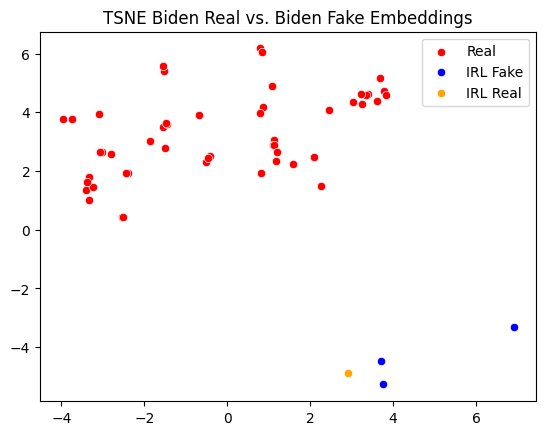

In [27]:
sns.scatterplot(x=X_embed[:50,0], y=X_embed[:50,1], color='red', label='Real')
sns.scatterplot(x=X_embed[50:53,0], y=X_embed[50:53,1], color='blue', label='IRL Fake')
sns.scatterplot(x=X_embed[53:54,0], y=X_embed[53:54,1], color='orange', label='IRL Real')
plt.title('TSNE Biden Real vs. Biden Fake Embeddings')
plt.show()

## Experiment #4

One known weakness is that ElevenLabs seems to be an easy problem to solve. As such, 

In [40]:
# 7 GANs folders
lj_full_band_mlegan_wav_folder = 'data/wavefake_data/generated_audio/ljspeech_full_band_melgan/16000KHz'
lj_hifigan_wav_folder = 'data/wavefake_data/generated_audio/ljspeech_hifiGAN/16000KHz'
lj_melgan_wav_folder = 'data/wavefake_data/generated_audio/ljspeech_melgan/16000KHz'
lj_melgan_large_wav_folder = 'data/wavefake_data/generated_audio/ljspeech_melgan_large/16000KHz'
lj_multi_band_melgan_wav_folder = 'data/wavefake_data/generated_audio/ljspeech_multi_band_melgan/16000KHz'
lj_parallel_wavegan_wav_folder = 'data/wavefake_data/generated_audio/ljspeech_parallel_wavegan/16000KHz'
lj_waveglow_wav_folder = 'data/wavefake_data/generated_audio/ljspeech_waveglow/16000KHz'

lf_real_wav_folder = 'data/wavefake_data/LJSpeech_1.1/wavs/16000KHz'

In [29]:
#load the real data, shuffle and sample 50 clips
n_train_samples = 100

lf_real_file_paths = load_data(lf_real_wav_folder)
random.shuffle(lf_real_file_paths)
lf_real_file_paths_sample = lf_real_file_paths[:n_train_samples]

sample_names = [path[len(path)-14:len(path)-4]+'_gen.wav' for path in lf_real_file_paths_sample]

In [61]:
lj_full_band_mlegan_file_paths_sample = load_data(lj_full_band_mlegan_wav_folder, sample_names)
lj_hifigan_file_paths_sample = load_data(lj_hifigan_wav_folder, sample_names)
lj_melgan_file_paths_sample = load_data(lj_melgan_wav_folder, sample_names)
lj_melgan_large_file_paths_sample = load_data(lj_melgan_large_wav_folder, sample_names)
lj_multi_band_melgan_file_paths_sample = load_data(lj_multi_band_melgan_wav_folder, sample_names)
lj_parallel_wavegan_file_paths_sample = load_data(lj_parallel_wavegan_wav_folder, sample_names)
lj_waveglow_file_paths_sample = load_data(lj_waveglow_wav_folder, sample_names)

In [63]:
lj_full_band_mlegan_embeddings = get_embeddings(model=speaker_model, file_paths=lj_full_band_mlegan_file_paths_sample)
lj_hifigan_embeddings = get_embeddings(model=speaker_model, file_paths=lj_hifigan_file_paths_sample)
lj_melgan_embeddings = get_embeddings(model=speaker_model, file_paths=lj_melgan_file_paths_sample)
lj_melgan_large_embeddings = get_embeddings(model=speaker_model, file_paths=lj_melgan_large_file_paths_sample)
lj_multi_band_melgan_embeddings = get_embeddings(model=speaker_model, file_paths=lj_multi_band_melgan_file_paths_sample)
lj_parallel_wavegan_embeddings = get_embeddings(model=speaker_model, file_paths=lj_parallel_wavegan_file_paths_sample)
lj_waveglow_embeddings = get_embeddings(model=speaker_model, file_paths=lj_waveglow_file_paths_sample)
lf_real_embeddings = get_embeddings(model=speaker_model, file_paths=lf_real_file_paths_sample)

In [48]:
#individual gan lables
lj_full_band_mlegan_labels_indv = [0]*lj_full_band_mlegan_embeddings.shape[0]
lj_hifigan_labels_indv = [1]*lj_hifigan_embeddings.shape[0]
lj_melgan_labels_indv = [2]*lj_melgan_embeddings.shape[0]
lj_melgan_large_labels_indv = [3]*lj_melgan_large_embeddings.shape[0]
lj_multi_band_melgan_labels_indv = [4]*lj_multi_band_melgan_embeddings.shape[0]
lj_parallel_wavegan_labels_indv = [5]*lj_parallel_wavegan_embeddings.shape[0]
lj_waveglow_labels_indv = [6]*lj_waveglow_embeddings.shape[0]
lf_real_labels_indv = [7]*lf_real_embeddings.shape[0]

In [49]:
#combine the data
X = np.concatenate((lj_full_band_mlegan_embeddings, lj_hifigan_embeddings, lj_melgan_embeddings, lj_melgan_large_embeddings, lj_multi_band_melgan_embeddings, lj_parallel_wavegan_embeddings, lj_waveglow_embeddings, lf_real_embeddings), axis=0)
y = np.concatenate((lj_full_band_mlegan_labels_indv, lj_hifigan_labels_indv, lj_melgan_labels_indv, lj_melgan_large_labels_indv, lj_multi_band_melgan_labels_indv, lj_parallel_wavegan_labels_indv, lj_waveglow_labels_indv, lf_real_labels_indv))

ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 2 dimension(s) and the array at index 1 has 1 dimension(s)

In [55]:
X = np.concatenate((lj_full_band_mlegan_embeddings, lj_melgan_embeddings, lj_melgan_large_embeddings, lj_multi_band_melgan_embeddings, lj_parallel_wavegan_embeddings, lj_waveglow_embeddings, lf_real_embeddings), axis=0)

ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 2 dimension(s) and the array at index 4 has 1 dimension(s)

In [60]:
lj_parallel_wavegan_embeddings.shape

(0,)

In [ ]:
#model = nemo_asr.models.EncDecSpeakerLabelModel(cfg)

In [ ]:
#model = nemo_asr.models.ASRModel.from_pretrained(model_name="titanet_large")

In [ ]:
#speaker_model = nemo_asr.models.EncDecSpeakerLabelModel.from_pretrained(model_name='titanet_large')

In [ ]:
#audio_path = r'/home/ubuntu/data/biden_wav_audio/16000KHz/09JW7Dmfs48_0_0.wav'
#speaker_model.get_embedding(audio_path)

In [ ]:
#librosa.get_samplerate(audio_path)

In [ ]:
import os
import soundfile as sf

In [ ]:

source_dir = 'data/wavefake_data/LJSpeech_1.1/wavs/Original'
target_dir = 'data/wavefake_data/LJSpeech_1.1/wavs/16000KHz'
target_sr = 16000
for file in os.listdir(os.path.join(home_path, source_dir)):
    y, sr = librosa.load(os.path.join(home_path, source_dir, file))
    resampled_audio = librosa.resample(y=y.T, orig_sr=sr, target_sr=target_sr)
    sf.write(os.path.join(home_path, target_dir, file), resampled_audio, target_sr, subtype='PCM_24')
   

In [ ]:

import shutil

path = 'data/wavefake_data/LJSpeech_1.1/wavs/'
for file in list(os.walk(os.path.join(home_path,path)))[0][2]:
    src_path = os.path.join(home_path, path, file)
    dest_path = os.path.join(home_path,path,'Original',file)
    shutil.move(src_path, dest_path)
    
